# Import Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns

# Decision Tree

In [6]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [8]:
X = iris.data[:,2:] # petal length and width
y = iris.target

print(X.shape)
print(y.shape)
print(iris.feature_names[2:])

(150, 2)
(150,)
['petal length (cm)', 'petal width (cm)']


In [9]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [30]:
# tree_image를 dot으로 저장
from sklearn.tree import export_graphviz

export_graphviz(    
    tree_clf,
    out_file = "iris_tree.dot",
    feature_names = iris.feature_names[2:],
    class_names = iris.target_names,
    rounded=True,
    filled=True
)

In [31]:
# dot을 png로 저장
import pydot

(graph,) = pydot.graph_from_dot_file('iris_tree.dot')
graph.write_png('iris_tree.png')

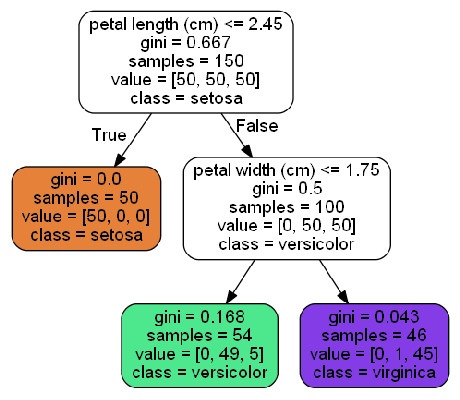

In [33]:
# png 이미지를 show
import matplotlib.image as mpimg

plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(mpimg.imread('iris_tree.png'))

### Gini Impurity
<br>
<br>
$$
G_i = 1 - \sum_{k=1}^n p_{i,k}^2
$$
<br>
$p_{i,k}$ is the ratio of class $k$ instances among the training instances in the $i^{th}$ node.
<br>
<br>
For example, the Gini score of the depth-2 left node is equal to $1- {0\over54}^2 + {49\over54}^2 + {5\over54}^2  = 0.168$
<br>
<br>

### Entropy
<br>
<br>
$$
H_i = \sum_{k=1}^n p_{i,k} log(p_{i,k})
$$
<br>
For example, the Entropy of the depth-2 left node is equal to  $-{49\over54}log({49\over54}) - {5\over54}log({5\over54}) = 0.445$
<br>
<br>

So should you use Gini impurity or entropy? **The truth is, most of the time it does not
make a big difference: they lead to similar trees.** Gini impurity is slightly faster to
compute, so it is a good default. However, when they differ, Gini impurity tends to
isolate the most frequent class in its own branch of the tree, while entropy tends to
produce slightly more balanced trees.

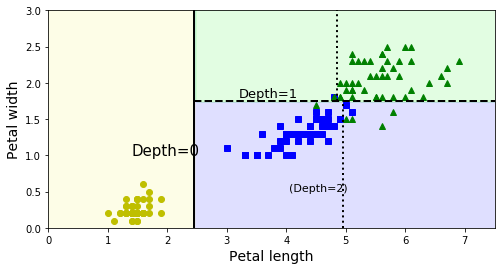

In [34]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

Figure above shows this Decision Tree’s decision boundaries. The thick vertical line represents
the decision boundary of the root node (depth 0): petal length = 2.45 cm.
Since the left area is pure (only Iris-Setosa), it cannot be split any further. However,
the right area is impure, so the depth-1 right node splits it at petal width = 1.75 cm
(represented by the dashed line). Since max_depth was set to 2, the Decision Tree
stops right there. However, if you set max_depth to 3, then the two depth-2 nodes
would each add another decision boundary (represented by the dotted lines).

# Estimating Class Probabilities

In [39]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [40]:
tree_clf.predict([[5, 1.5]])

array([1])

# The CART Training Algorithm

Scikit-Learn uses the Classification And Regression Tree (CART) algorithm to train
Decision Trees (also called “growing” trees). The idea is really quite simple: the algorithm
first splits the training set in two subsets using a single feature $k$ and a threshold
$t_k$ (e.g., “petal length ≤ 2.45 cm”). How does it choose $k$ and $t_k$? It searches for the
pair ($k$, $t_k$) that produces the purest subsets (weighted by their size). The cost function
that the algorithm tries to minimize is given by equation below.
<br>
<br>
$$
J(k, t_k) = {m_{left} \over m}G_{left} + {m_{right} \over m}G_{right}
$$
<br>
<br>
$$
where 
\begin{cases}
G_{left/right} \; \text{measures the impurity of the left/right subset.}\\
m_{left/right} \; \text{is the number of instances in the left/right subset.}
\end{cases}
$$
<br>
<br>
Once it has successfully split the training set in two, it splits the subsets using the
same logic, then the sub-subsets and so on, recursively. It stops recursing once it reaches
the maximum depth (defined by the max_depth hyperparameter), or if it cannot
find a split that will reduce impurity. A few other hyperparameters (described in a
moment) control additional stopping conditions (min_samples_split, min_sam
ples_leaf, min_weight_fraction_leaf, and max_leaf_nodes).


As you can see, the CART algorithm is a greedy algorithm: it greedily
searches for an optimum split at the top level, then repeats the
process at each level. It does not check whether or not the split will
lead to the lowest possible impurity several levels down. A greedy
algorithm often produces a reasonably good solution, but it is not
guaranteed to be the optimal solution.
Unfortunately, finding the optimal tree is known to be an *NP-Complete
problem*: it requires $O(exp(m))$ time, making the problem
intractable even for fairly small training sets. This is why we
must settle for a “reasonably good” solution.

### DT Algorithms in Scikit-Learn
Scikit-Learn uses the CART algorithm, which produces only binary
trees: nonleaf nodes always have two children (i.e., questions only
have yes/no answers). However, other algorithms such as ID3 can
produce Decision Trees with nodes that have more than two children.
<br>
<br>
**One of the many qualities of DT is that they require very little data preperation. In particular, they don't require feature scaling at all.**

# Computational Complexity

Making predictions requires traversing the Decision Tree from the root to a leaf.
Decision Trees are generally approximately balanced, so traversing the Decision Tree
requires going through roughly O(log2(m)) nodes.3 Since each node only requires
checking the value of one feature, the overall prediction complexity is just $O(log2(m))$,
independent of the number of features. So predictions are very fast, even when dealing
with large training sets.<br><br>
However, the training algorithm compares all features (or less if max_features is set)
on all samples at each node. This results in a training complexity of $O(n × m log(m))$.
For small training sets (less than a few thousand instances), Scikit-Learn can speed up
training by presorting the data (set presort=True), but this slows down training considerably
for larger training sets.

# Regularization Hyperparameters

Decision Trees make very few assumptions about the training data (as opposed to linear
models, which obviously assume that the data is linear, for example). If left
unconstrained, the tree structure will adapt itself to the training data, fitting it very
closely, and most likely overfitting it. Such a model is often called a nonparametric
model, not because it does not have any parameters (it often has a lot) but because the
number of parameters is not determined prior to training, so the model structure is
free to stick closely to the data. In contrast, a parametric model such as a linear model
has a predetermined number of parameters, so its degree of freedom is limited,
reducing the risk of overfitting (but increasing the risk of underfitting).<br><br>
To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom
during training. As you know by now, this is called regularization. The regularization
hyperparameters depend on the algorithm used, but generally you can at least restrict
the maximum depth of the Decision Tree. In Scikit-Learn, this is controlled by the
max_depth hyperparameter (the default value is None, which means unlimited).
Reducing max_depth will regularize the model and thus reduce the risk of overfitting.

For `DeicsionTreeClassifier`,
* `max_depth` : restrict the maximum depth of the Decision Tree
* `min_samples_split` : the minimum number of samples a node must have before it can be split
* `min_samples_leaf` : the minimum number of samples a leaf node must have
* `min_weight_fraction_leaf` : same as min_samples_leaf but expressed as a fraction of the total number of weighted instances
* `max_leaf_nodes` : maximum number of leaf nodes
* `max_features` : maximum number of features that are evaluated for splitting at each node
<br>

Increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the
model.

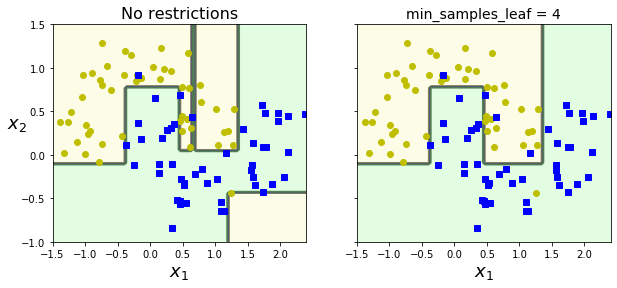

In [42]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

plt.show()

# Regression

In [52]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [53]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [58]:
# tree_image를 dot으로 저장
from sklearn.tree import export_graphviz

export_graphviz(    
    tree_reg,
    out_file = "iris_tree2.dot",
    rounded=True,
    filled=True
)

In [59]:
# dot을 png로 저장
import pydot

(graph,) = pydot.graph_from_dot_file('iris_tree2.dot')
graph.write_png('iris_tree2.png')

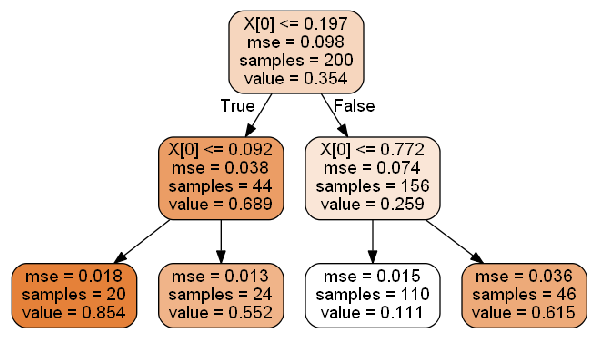

In [62]:
# png 이미지를 show
import matplotlib.image as mpimg

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(mpimg.imread('iris_tree2.png'))

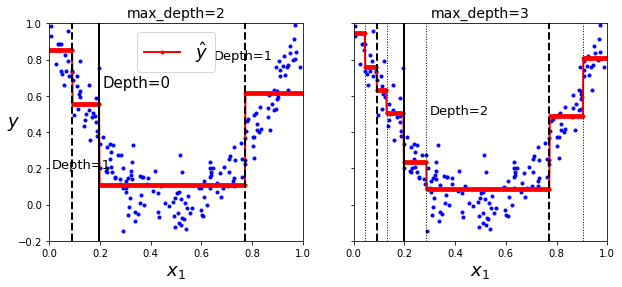

In [63]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

The CART algorithm works mostly the same way as earlier, except that instead of trying
to split the training set in a way that minimizes impurity, it now tries to split the
training set in a way that minimizes the MSE. Equation below shows the cost function
that the algorithm tries to minimize.
<br>
<br>
<br>
$$
J(k, t_k) = {m_{left} \over m}MSE_{left} + {m_{right} \over m}MSE_{right}
$$
<br>
<br>
$$
where 
\begin{cases}
MSE_{node} = \sum_{i \in node} (\hat{y}_{node} - y^{(i)})^2\\
\hat{y}_{node} = {1\over m_{node}} \sum_{i \in node} y^{(i)}
\end{cases}
$$
<br>
<br>


### Regularization in Regression

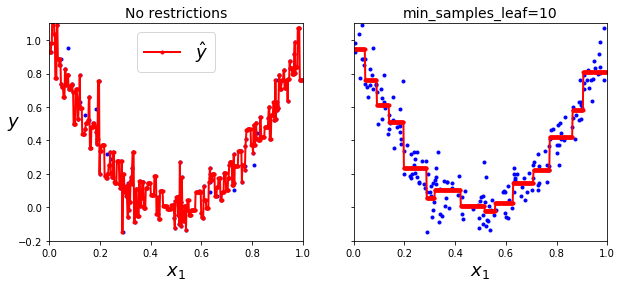

In [65]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

# Instability

Hopefully by now you are convinced that Decision Trees have a lot going for them:
they are simple to understand and interpret, easy to use, versatile, and powerful.
However they do have a few limitations. First, as you may have noticed, Decision
Trees love orthogonal decision boundaries (all splits are perpendicular to an axis),
which makes them sensitive to training set rotation. For example, Figure below shows a
simple linearly separable dataset: on the left, a Decision Tree can split it easily, while
on the right, after the dataset is rotated by 45°, the decision boundary looks unnecessarily
convoluted. Although both Decision Trees fit the training set perfectly, it is very
likely that the model on the right will not generalize well. One way to limit this problem
is to use PCA (see Chapter 8), which often results in a better orientation of the
training data.

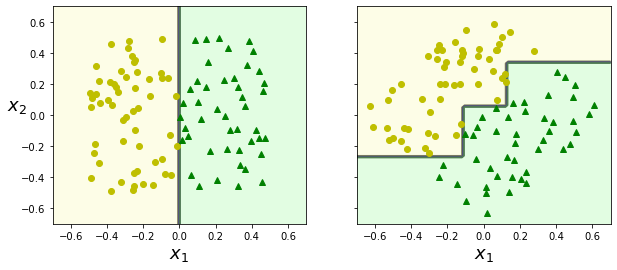

In [70]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

plt.show()

More generally, the main issue with Decision Trees is that they are very sensitive to
small variations in the training data. For example, if you just remove the widest Iris-
Versicolor from the iris training set (the one with petals 4.8 cm long and 1.8 cm wide)
and train a new Decision Tree, you may get the model represented in Figure above. As
you can see, it looks very different from the previous Decision Tree.
Actually, since the training algorithm used by Scikit-Learn is stochastic you may
get very different models even on the same training data (unless you set the
random_state hyperparameter).<br><br>
**Random Forests can limit this instability by averaging predictions over many trees, as
we will see in the next chapter.**

In [67]:
X = iris.data[:,2:] # petal length and width
y = iris.target

not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=40, splitter='best')

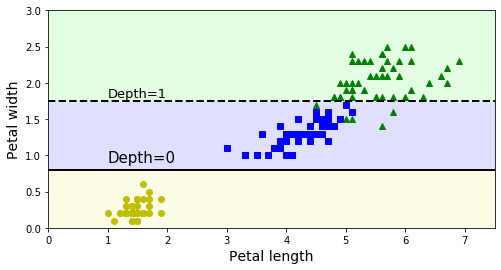

In [68]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

plt.show()